In [4]:
import numpy as np
import matplotlib.pyplot as plt
from miniSMLM import generators, localize, utils, psf

### Parameters 

In [5]:
config = {
    "particles": 7,
    "npixels": 50,
    "sigma": 0.92,
    "N0": 1000,
    "eta": 1.0,
    "texp": 1.0,
    "max_iters":100,
    "tol":1e-4,
    "lr":[1e-4,1e-4,0,100.0],
    "gain": "run/cmos/gain.npz",
    "offset": "run/cmos/offset.npz",
    "var": "run/cmos/var.npz",
    "patchw": 3}


### Generate some toy data of emitters spaced on a ring

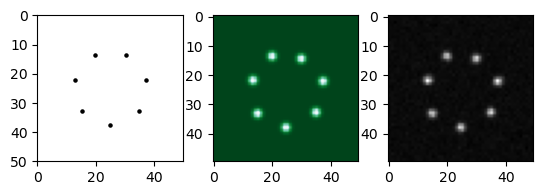

In [6]:
ring = generators.Ring2D(config)
adu = ring.forward(show=True,ring_radius=config['npixels']/4)

### Run a detection algorithm to localize the emitters

In [7]:
detector = localize.LoGDetector(adu,threshold=10.0)
spots = detector.detect()
detector.show(adu)
print(spots)

NameError: name 'r' is not defined

### Run a maximum likelihood estimation to localize the emitters with sub-pixel precision

In [2]:
cmos_params = [config['eta'],config['texp'],
               np.load(config['gain'])['arr_0'],
               np.load(config['offset'])['arr_0'],
               np.load(config['var'])['arr_0']]

for i in spots.index:
    patchw = config['patchw']
    x0 = int(spots.at[i,'x'])
    y0 = int(spots.at[i,'y'])
    patch = adu[x0-patchw:x0+patchw+1,y0-patchw:y0+patchw+1]
    patch = patch - cmos_params[3]
    patch = np.clip(patch,0,None)
    theta0 = np.array([patchw,patchw,config['sigma'],config['N0']])
    opt = psf.MLE2D(theta0,patch,config) #cartesian coordinates with top-left origin
    theta_mle, loglike, converged = opt.optimize(max_iters=config['max_iters'],
                                                 plot_fit=False,
                                                 tol=config['tol'],
                                                 lr=config['lr'])
    dx = theta_mle[1] - patchw; dy = theta_mle[0] - patchw
    spots.loc[i, 'x_mle'] = x0 + dx #switch back to image coordinates
    spots.loc[i, 'y_mle'] = y0 + dy
    spots.loc[i, 'N0'] = theta_mle[3]

NameError: name 'config' is not defined

### Generate the super-resolution image by Gaussian kernel density estimation (KDE)

In [3]:
kde = utils.KDE(spots)
render = kde.forward()
fig,ax=plt.subplots()
ax.imshow(render,cmap='gray'); plt.show()

NameError: name 'utils' is not defined